### load dependencies

In [1]:
import torch, os
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
pd.set_option('display.max_colwidth', 100)

In [2]:
print("PyTorch version: ", torch.__version__)

PyTorch version:  2.5.1+cu124


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: ", device)

Using device:  cuda


### data pipeline

In [4]:
def rating_to_sentiment(rating):
    if rating < 3:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

def load_data(data_path='data/reviews_v2.csv'):
    if data_path.endswith('.csv'):
        data = pd.read_csv(data_path)
    else:
        data = pd.read_excel(data_path)
    data = data.sample(frac=1).reset_index(drop=True)
    data = data[data['reviews.rating'].isin([1, 2, 3, 4, 5])]
    data['sentiment'] = data['reviews.rating'].apply(rating_to_sentiment)
    data = data[['reviews.text', 'sentiment']]
    data.rename(
                columns={
                        'reviews.text': 'text'
                        }, 
                inplace=True
                )
    data.dropna(inplace=True)
    return data

def visualize_data(data):
    value_counts = data['sentiment'].value_counts()
    value_counts_df = pd.DataFrame(value_counts)
    value_counts_df.reset_index(inplace=True)
    value_counts_df.columns = ['sentiment', 'Count']


    plt.figure(figsize=(10, 5))
    sns.barplot(value_counts_df, x='sentiment', y='Count')
    for _, row in value_counts_df.iterrows():
        plt.text(row.name, row.Count, row.Count, color='black', ha="center")
    plt.title('Sentiment Distribution')
    plt.show()

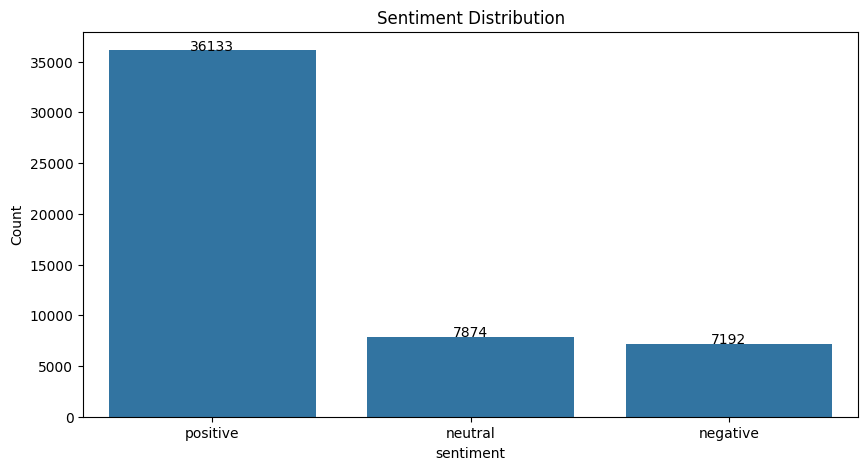

In [5]:
data = load_data()
visualize_data(data)

In [6]:
def sample_data(
                data,
                n_samples=10000,
                sentiment2id = {
                                "negative" : 0, 
                                "positive" : 1,
                                "neutral" : 2
                                }
                ):
    sentiments = data['sentiment'].unique()
    id2sentiment = {v: k for k, v in sentiment2id.items()}

    data_sampled = pd.DataFrame()
    for sentiment in sentiments:
        sentiment_data = data[data['sentiment'] == sentiment]
        n_samples_sentiment = n_samples - len(sentiment_data)
        if n_samples_sentiment > 0:
            upsampled_data = sentiment_data.sample(n=n_samples_sentiment, replace=True)
            data_sampled = pd.concat([data_sampled, sentiment_data, upsampled_data], axis=0)

        else:
            if len(sentiment_data) > n_samples * 1.5:
                downsampled_data = sentiment_data.sample(n=int(n_samples * 1.5), replace=False)
                data_sampled = pd.concat([data_sampled, downsampled_data], axis=0)
            else:
                data_sampled = pd.concat([data_sampled, sentiment_data], axis=0)

    return data_sampled, sentiment2id, id2sentiment

def vis_wordcloud(data):
    texts = data['text'].values
    labels = data['sentiment'].values
    pos_texts = texts[labels == 'positive']
    neg_texts = texts[labels == 'negative']
    neutral_texts = texts[labels == 'neutral']

    plt.figure(figsize=(30, 20))
    plt.subplot(1, 3, 1)

    wordcloud = WordCloud(width=1600, height=800).generate(' '.join(pos_texts))
    plt.title('Positive Reviews')
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    wordcloud = WordCloud(width=1600, height=800).generate(' '.join(neutral_texts))
    plt.title('Neutral Reviews')
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    wordcloud = WordCloud(width=1600, height=800).generate(' '.join(neg_texts))
    plt.title('Negative Reviews')
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

def data_pipeline(data_path=None):
    data = load_data(data_path)
    vis_wordcloud(data)

    data, sentiment2id, id2sentiment = sample_data(data)
    visualize_data(data)

    data['sentiment'] = data['sentiment'].map(sentiment2id)
    data = data.sample(frac=1).reset_index(drop=True)
    data.to_csv('data/data_sampled.csv', index=False)

    texts = data['text'].values
    labels = data['sentiment'].values
    return texts, labels, sentiment2id, id2sentiment

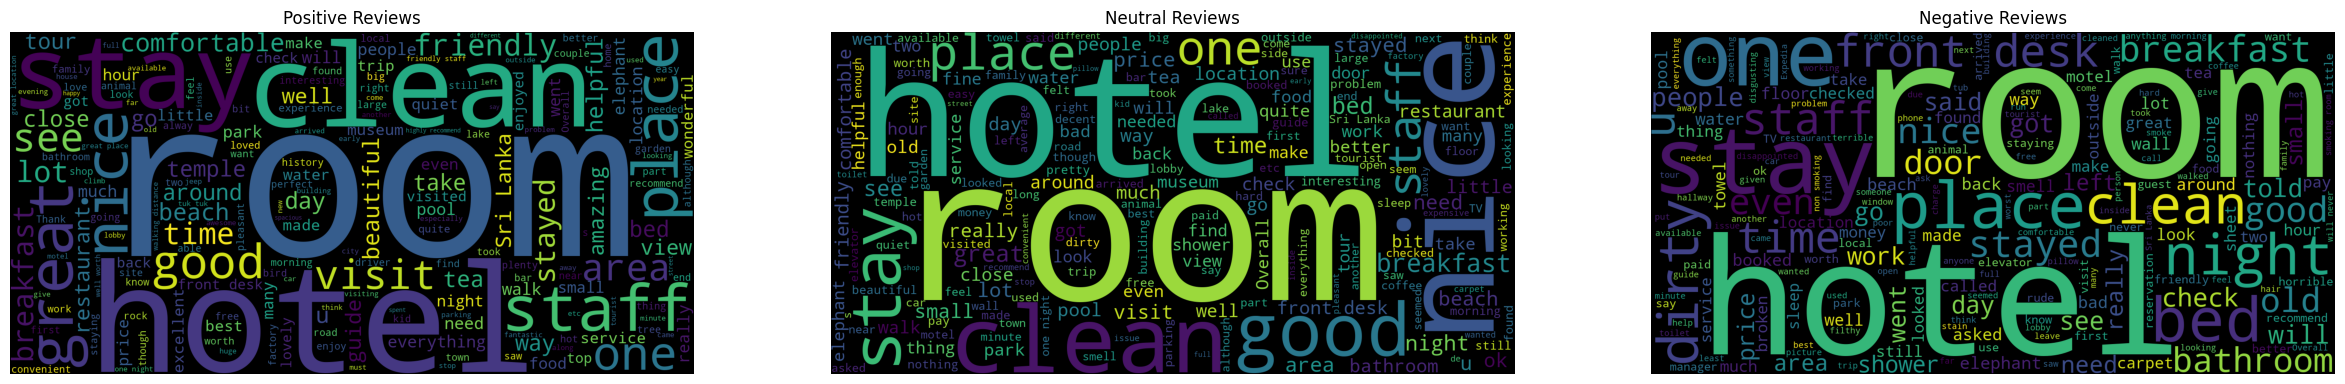

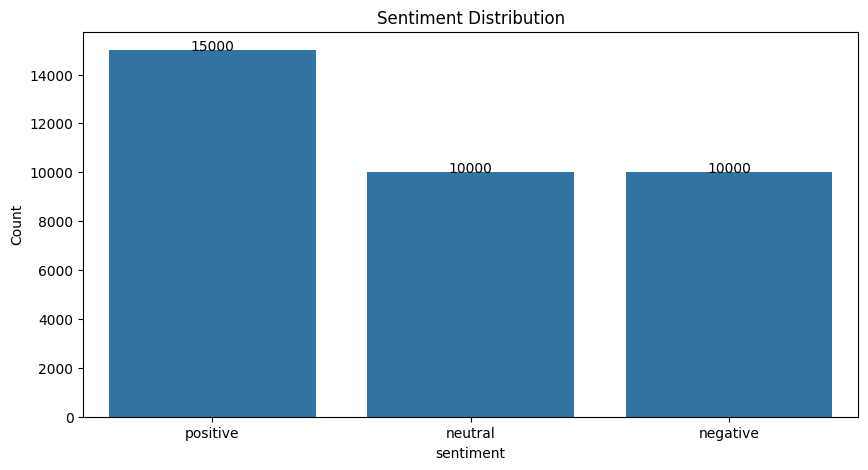

In [7]:
texts, labels, sentiment2id, id2sentiment = data_pipeline(data_path='data/reviews_v2.csv')

In [8]:
text_train, text_test, label_train, label_test = train_test_split(
                                                                texts, 
                                                                labels, 
                                                                test_size=0.15, 
                                                                random_state=42
                                                                )

print('Number of training samples:', len(text_train))
print('Number of testing samples:', len(text_test))

Number of training samples: 29750
Number of testing samples: 5250


### training huggingface model

In [9]:
model_card = "cardiffnlp/twitter-roberta-base-sentiment"

model_roberta = AutoModelForSequenceClassification.from_pretrained(
                                                                model_card, 
                                                                num_labels=len(sentiment2id),
                                                                ignore_mismatched_sizes=True
                                                                )
tokenizer_roberta = AutoTokenizer.from_pretrained(model_card)
model_roberta = model_roberta.to('cuda')

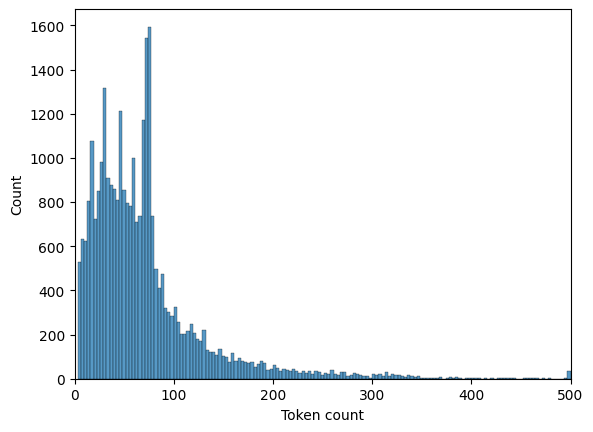

count    29750.000000
mean        70.364101
std         59.983029
min          3.000000
25%         32.000000
50%         58.000000
75%         82.000000
90%        136.000000
95%        187.000000
99%        315.000000
max        500.000000
dtype: float64


In [10]:
token_lens = []
for txt in text_train:
    tokens = tokenizer_roberta.encode(
                                    txt, 
                                    max_length=500,
                                    truncation=True
                                    )
    token_lens.append(len(tokens))

sns.histplot(token_lens)
plt.xlim([0, 500])
plt.xlabel('Token count')
plt.show()

token_lens_series = pd.Series(token_lens)
print(token_lens_series.describe(
                                percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
                                ))

In [11]:
class SentimentTextDataset(object):
    def __init__(
                self, 
                tokenizer, 
                texts, 
                labels,
                max_len
                ):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
                                            text,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            return_token_type_ids=False,
                                            padding='max_length',
                                            return_attention_mask=True,
                                            return_tensors='pt',
                                            truncation=True
                                            )

        return {
                'text' : text,
                'input_ids' : encoding['input_ids'].flatten(),
                'attention_mask' : encoding['attention_mask'].flatten(),
                'label' : torch.tensor(label, dtype=torch.long)
                }

In [12]:
train_dataset = SentimentTextDataset(
                            tokenizer_roberta, 
                            text_train, label_train, 150
                            )

test_dataset = SentimentTextDataset(
                            tokenizer_roberta, 
                            text_test, label_test, 150
                            )           

In [13]:
def calculate_accuracy(preds, labels):
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    score = accuracy_score(labels, preds)
    return round(score, 3)

def calculate_f1(preds, labels):
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    score = f1_score(labels, preds, average='weighted')
    return round(score, 3)

In [14]:
training_args = TrainingArguments(                                
                                num_train_epochs=30,
                                output_dir='./artifacts/HotelReviewSentiments',
                                logging_dir='./logs/HotelReviewSentiments',
                                per_device_train_batch_size=16,
                                per_device_eval_batch_size=16,
                                save_total_limit=3,
                                logging_steps=1000,
                                warmup_steps=1000,
                                weight_decay=0.01,
                                save_steps=5000
                                )

trainer = Trainer(  
                args=training_args,
                model=model_roberta,    
                eval_dataset=test_dataset,
                train_dataset=train_dataset,
                compute_metrics=[
                                calculate_accuracy, 
                                calculate_f1
                                ]
                )
trainer.train()

  0%|          | 0/55800 [00:00<?, ?it/s]

{'loss': 0.773, 'grad_norm': 5.99794340133667, 'learning_rate': 5e-05, 'epoch': 0.54}
{'loss': 0.6656, 'grad_norm': 8.973260879516602, 'learning_rate': 4.908759124087591e-05, 'epoch': 1.08}
{'loss': 0.577, 'grad_norm': 7.1313700675964355, 'learning_rate': 4.817518248175183e-05, 'epoch': 1.61}
{'loss': 0.5247, 'grad_norm': 7.619046688079834, 'learning_rate': 4.726277372262774e-05, 'epoch': 2.15}
{'loss': 0.4394, 'grad_norm': 6.840960502624512, 'learning_rate': 4.635036496350365e-05, 'epoch': 2.69}
{'loss': 0.3983, 'grad_norm': 30.905838012695312, 'learning_rate': 4.5437956204379564e-05, 'epoch': 3.23}
{'loss': 0.3406, 'grad_norm': 20.38987922668457, 'learning_rate': 4.452554744525548e-05, 'epoch': 3.76}
{'loss': 0.3114, 'grad_norm': 0.8138488531112671, 'learning_rate': 4.361313868613139e-05, 'epoch': 4.3}
{'loss': 0.2959, 'grad_norm': 2.6924991607666016, 'learning_rate': 4.27007299270073e-05, 'epoch': 4.84}
{'loss': 0.2554, 'grad_norm': 4.976147651672363, 'learning_rate': 4.178832116788

TrainOutput(global_step=55800, training_loss=0.15332039108413095, metrics={'train_runtime': 17501.9454, 'train_samples_per_second': 50.994, 'train_steps_per_second': 3.188, 'total_flos': 6.879747812175e+16, 'train_loss': 0.15332039108413095, 'epoch': 30.0})

In [29]:
tokenizer_roberta.save_pretrained('./artifacts/HotelReviewSentiments')
model_roberta.save_pretrained('./artifacts/HotelReviewSentiments')

### Inference

In [ ]:
tokenizer_roberta = AutoTokenizer.from_pretrained('./artifacts/HotelReviewSentiments')
model_roberta = AutoModelForSequenceClassification.from_pretrained('./artifacts/HotelReviewSentiments')
model_roberta = model_roberta.to('cuda')

In [4]:
def inference_on_text(text):
      encoding = tokenizer_roberta.encode_plus(
                                                text,
                                                max_length=150,
                                                truncation=True,
                                                return_tensors='pt',
                                                padding='max_length',
                                                add_special_tokens=True,
                                                return_attention_mask=True,
                                                return_token_type_ids=False
                                                )
      
      input_ids = encoding['input_ids'].flatten().unsqueeze(0).to('cuda')
      attention_mask = encoding['attention_mask'].flatten().unsqueeze(0).to('cuda')
      
      output = model_roberta(input_ids, attention_mask)
      _, prediction = torch.max(output.logits, dim=1)
      prediction = prediction.cpu().numpy().item()
      return id2sentiment[prediction]

In [ ]:
inference_on_text('Excellent')

NameError: name 'tokenizer_roberta' is not defined

### evaluation

In [33]:
P_test = []
for idx, text in enumerate(text_test):
    P = inference_on_text(text)
    P_test.append(P)

    print(f"{idx+1}/{len(text_test)} processed", end='\r')

In [34]:
pred_test = [sentiment2id[pred] for pred in P_test]
clf_report = classification_report(
                                    label_test, 
                                    pred_test, target_names=list(sentiment2id.keys())
                                    )
print(clf_report)

              precision    recall  f1-score   support

    negative       0.85      0.83      0.84      1547
    positive       0.87      0.82      0.84      2278
     neutral       0.65      0.71      0.68      1425

    accuracy                           0.80      5250
   macro avg       0.79      0.79      0.79      5250
weighted avg       0.80      0.80      0.80      5250



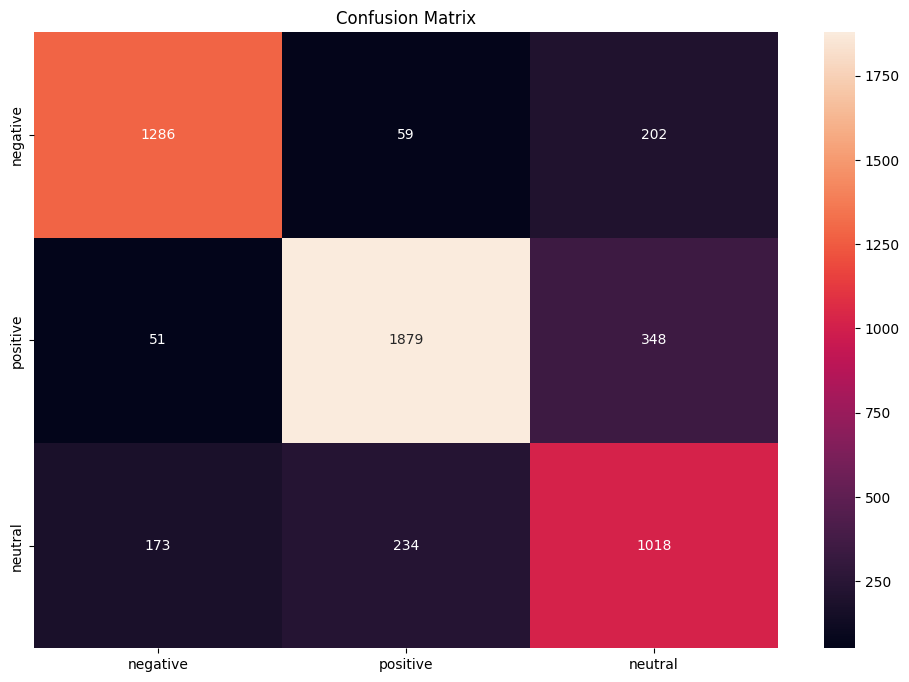

In [35]:
cm = confusion_matrix(label_test, pred_test)
plt.figure(figsize=(12, 8))
sns.heatmap(
            cm, 
            annot=True, fmt="d",
            xticklabels=list(sentiment2id.keys()), 
            yticklabels=list(sentiment2id.keys())
            )
plt.title('Confusion Matrix')
plt.show()

### API Data

In [38]:
import os, yaml
from llama_index.core.llms import (
    
                                ChatMessage,
                                MessageRole
                                )
from llama_index.core import Settings, ChatPromptTemplate
from IPython.display import display, Markdown
from llama_index.llms.groq import Groq

In [41]:
data_path = 'data/reviews_v2.csv'
df_reviews = pd.read_csv(data_path)
df_reviews['sentiment'] = df_reviews['reviews.rating'].apply(rating_to_sentiment)
del df_reviews['reviews.rating']
df_reviews.to_csv('data/reviews_with_sentiments.csv', index=False)

In [37]:
with open('secrets.yaml') as f:
    secrets = yaml.load(f, Loader=yaml.FullLoader)

os.environ["GROQ_API_KEY"] = secrets['GROQ_API_KEY']

completion_llm = Groq(
                    model="llama3-70b-8192", 
                    api_key=os.environ["GROQ_API_KEY"],
                    temperature=0.3
                    )
Settings.llm = completion_llm

In [42]:
if not os.path.exists('data/reviews_with_sentiments.csv'):
    data_path = 'data/reviews_v2.csv'
    df_reviews = pd.read_csv(data_path)
    del df_reviews['reviews.rating']

    for idx in range(len(df_reviews)):
        review = df_reviews.loc[idx, 'reviews.text']
        sentiment = inference_on_text(review)
        df_reviews.loc[idx, 'sentiment'] = sentiment
        print(f"{idx+1}/{len(df_reviews)} processed", end='\r')

    df_reviews.to_csv('data/reviews_with_sentiments.csv', index=False)

df_reviews = pd.read_csv('data/reviews_with_sentiments.csv')
df_reviews.head()

,Location_Name,Location_Type,User_ID,User_Location,User_Locale,User_Contributions,Travel_Date,Published_Date,reviews.text,sentiment
0,Arugam Bay,Beaches,User_1,"Dunsborough, Australia",en_US,81,2019-07-01,2019-07-31,I had a manicure here and it really was professional and clean. It is right on the Ocean so ver...,positive
1,Arugam Bay,Beaches,User_2,"Bendigo, Australia",en_US,34,2019-06-01,2019-07-21,"Overall, it is a wonderful experience. We visited Arugam bay last month during our anniversary. ...",positive
2,Arugam Bay,Beaches,User_3,"Melbourne, Australia",en_US,66,2019-07-01,2019-07-15,"Great place to chill, swim, surf, eat, shop, have sunset cocktails, it??s the best!!! The vibe i...",positive
3,Arugam Bay,Beaches,User_4,"Ericeira, Portugal",en_US,76,2019-06-01,2019-07-03,Good place for surf and a few stores to going for shopping. Very good place for rest and surf. G...,positive
4,Arugam Bay,Beaches,User_5,"Pistoia, Italy",en_US,18,2019-07-01,2019-07-02,This place is great for surfing but even if you are not a surfer you can have a wonderful time s...,positive


In [45]:
def get_review_stats(
                    hotel_name,
                    sentiment_path = 'data/reviews_with_sentiments.csv'
                    ):  
    df_reviews = pd.read_csv(sentiment_path)
    df_reviews = df_reviews[df_reviews['Location_Name'] == hotel_name]
    
    pos_reviews = df_reviews[df_reviews['sentiment'] == 'positive']
    neg_reviews = df_reviews[df_reviews['sentiment'] == 'negative']
    neutral_reviews = df_reviews[df_reviews['sentiment'] == 'neutral']

    pos_count, neg_count, neutral_count = len(pos_reviews), len(neg_reviews), len(neutral_reviews)
    pos_reviews = pos_reviews['reviews.text'].values
    neg_reviews = neg_reviews['reviews.text'].values

    pos_reviews = pos_reviews[:10]
    neg_reviews = neg_reviews[:10]

    pos_df = pd.DataFrame(pos_reviews, columns=['Positive Reviews'])
    neg_df = pd.DataFrame(neg_reviews, columns=['Negative Reviews'])

    pos_df['Negative Reviews'] = neg_df['Negative Reviews']
    print("================ Positive and Negative Reviews ================")
    print(pos_df)

    # bar blots
    plt.figure(figsize=(10, 5))
    plt.bar(['Positive', 'Negative', 'Neutral'], [pos_count, neg_count, neutral_count])
    for i, count in enumerate([pos_count, neg_count, neutral_count]):
        plt.text(i, count, count, color='black', ha="center")
    plt.title(f"Sentiment Distribution for {hotel_name}")
    plt.show()

    # pie chart
    labels = ['Positive', 'Negative', 'Neutral']
    sizes = [pos_count, neg_count, neutral_count]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')
    plt.title(f"Sentiment Distribution for {hotel_name}")
    plt.show()


================ Positive and Negative Reviews ================
                                                                                      Positive Reviews  \
0                         Mysigt med fina rum, bra frukost och nra bde till stranden och btterminalen.   
1  Wunderschne Zimmer, Bademantelgang optimal, Frhstck sehr lecker in gemtlicher Atmosphre. Parkpla...   
2                                                                     Quiet, friendly staff, no issues   
3  We have stayed here on two different occasions and could not be happier. Very clean !!! Staff pl...   
4  This is a nice resort town hotel. The pool is a nice area but in real need of cleaning. I saw re...   
5  We checked into La Quinta and were surprised at how nice this location was. It has been some tim...   
6                                        as far as i know from my clients it is the nest hotel in town   
7                         Julie, the manager was GREAT! Very helpful and knowledgeable a

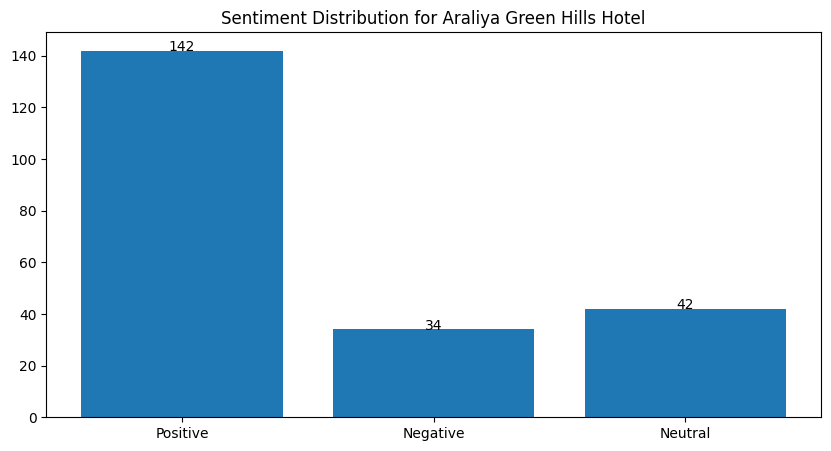

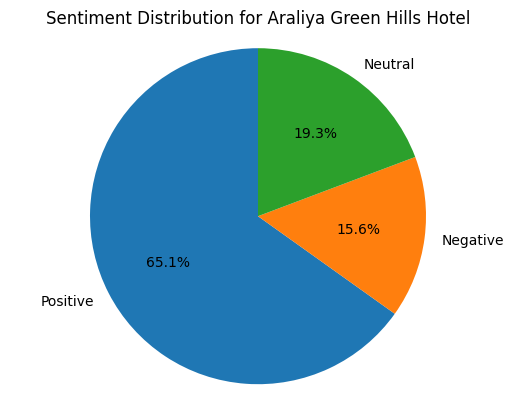

In [46]:
get_review_stats("Araliya Green Hills Hotel")

In [47]:
def generate_solutions(
                    hotel_name,
                    sentiment_path = 'data/reviews_with_sentiments.csv'
                    ):  
        df_reviews = pd.read_csv(sentiment_path)
        df_reviews = df_reviews[df_reviews['Location_Name'] == hotel_name]
        neg_reviews = df_reviews[df_reviews['sentiment'] == 'negative']['reviews.text'].values.squeeze().tolist()

        output_format = {
                        "Solutions" : [
                                "solution 01",
                                "solution 02",
                                "solution 03",       
                                ],
                        "Issues" : [
                                "issue 01",
                                "issue 02",
                                "issue 03",       
                                ]
                        }
        review_gen_template = ChatPromptTemplate(
                                                message_templates=[
                                                                ChatMessage(
                                                                        role=MessageRole.SYSTEM, 
                                                                        content="""
                                                                        You are an expert in hotel industry and you have been asked to provide solutions to improve the hotel's reputation. customer have left below negative reviews for the hotel.

                                                                        ----------------------------------------------------------------
                                                                        {neg_reviews}
                                                                        ----------------------------------------------------------------

                                                                        based on them you have to do below 2 things
                                                                                1. Provide 10 solutions based on the negative reviews to improve the hotel's reputation.
                                                                                2. summarize the negative reviews into different issue types and order them by the number of reviews they appear in.

                                                                        return the output in below format. 
                                                                        
                                                                        -----------------------------------------------------------------
                                                                        {output_format}
                                                                        -----------------------------------------------------------------
                                                                        
                                                                        do not return any other text only JSON
                                                                        """                                     
                                                                        )
                                                                ]
                                                )
        fmt_messages = review_gen_template.format_messages(
                                                        neg_reviews=neg_reviews,
                                                        output_format=output_format
                                                        )      
        chat_response = completion_llm.chat(fmt_messages)
        raw_output = chat_response.message.content
        return raw_output

In [48]:
raw_output = generate_solutions("Araliya Green Hills Hotel")
print(raw_output)

{
"Solutions": [
"Implement a thorough room inspection process to ensure cleanliness and maintenance of rooms",
"Provide a variety of breakfast options and improve the quality of food and utensils",
"Train staff to be more responsive to customer complaints and provide timely solutions",
"Consider renovating the hotel to modernize the facilities and amenities",
"Improve the check-in and check-out process to reduce wait times and errors",
"Enhance customer service by being more transparent about hotel policies and amenities",
"Address the issue of pets in the hotel by providing pet-free rooms or areas",
"Improve the quality of beds and bedding to ensure a comfortable stay",
"Provide clear information about the hotel's amenities and services on the website",
"Implement a system to address and resolve customer complaints in a timely manner"
],
"Issues": [
"Cleanliness and maintenance of rooms (14)",
"Quality of food and breakfast options (5)",
"Customer service and responsiveness (5)",
"Ou